In [1]:
from utils import *
from richutils import *
warnings.filterwarnings("ignore")

df = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))
df


,Index,Price,Production,Withdrawals,GlobalPrice,ExchangeRate,TempMax,TempAvg,Precipitation,Inflation
Month,,,,,,,,,,
2014-09-01,1,51.51,537770.0,1418420,0.1470,44.08,28,27,456.59,3.9
2014-10-01,2,51.46,1623075.0,1355836,0.1648,44.80,29,27,436.73,3.7
2014-11-01,3,51.28,2277043.0,2156729,0.1588,44.95,29,28,265.32,3.0
2014-12-01,4,51.65,2223994.0,1663150,0.1499,44.69,28,27,182.00,1.9
2015-01-01,5,51.19,2259613.0,1714490,0.1506,44.60,28,27,82.83,1.5
...,...,...,...,...,...,...,...,...,...,...
2024-04-01,116,85.85,1476667.0,1042072,0.2069,56.95,33,29,22.90,3.8
2024-05-01,117,85.54,590428.0,1177536,0.1880,57.76,32,29,130.78,3.9
2024-06-01,118,86.73,470766.0,1183388,0.1916,58.70,30,28,330.53,3.7


In [2]:
kg = 0.453592
globalPrice = (df['GlobalPrice']/ kg )*df['ExchangeRate'] 


In [3]:
globalPrice

Month
2014-09-01    14.285437
2014-10-01    16.276830
2014-11-01    15.736741
2014-12-01    14.768847
2015-01-01    14.807933
                ...    
2024-04-01    25.976990
2024-05-01    23.939752
2024-06-01    24.795234
2024-07-01    24.960158
2024-08-01    23.236999
Length: 120, dtype: float64

In [4]:
forecast_df = pd.read_csv('combined_forecast.csv')
forecast_df.set_index('Month', inplace=True)

x1 = forecast_df['Production']
x2 = forecast_df['Withdrawals']
x3 = (forecast_df['GlobalPrice'] / kg )*forecast_df['ExchangeRate']
x4 = forecast_df['ExchangeRate']
x6 = forecast_df['Precipitation']
x5 = forecast_df['Temperature']
x7 = forecast_df['Inflation']


In [5]:
price = df['Price']
production = df['Production'] 
withdrawals = df['Withdrawals']
exchangeRate = df['ExchangeRate']
globalPrice.name = 'GlobalPrice'
temperature = df['TempMax']
precipitation = df['Precipitation']
inflation = df['Inflation']

<Axes: xlabel='Month'>

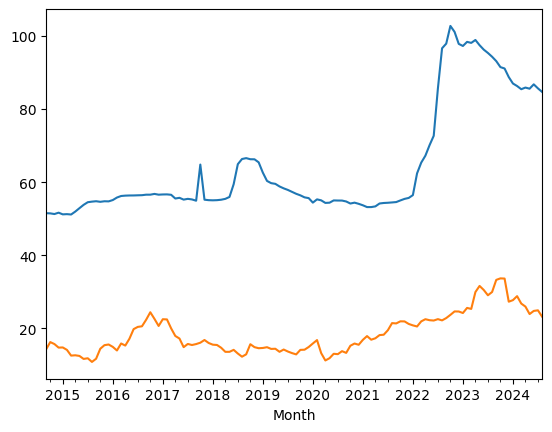

In [6]:
price.plot()
globalPrice.plot()

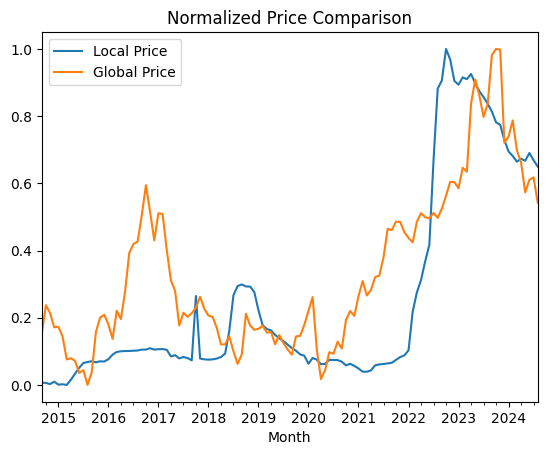

In [7]:
# Min-max normalization
normalized_price = (price - price.min()) / (price.max() - price.min())
normalized_globalPrice = (globalPrice - globalPrice.min()) / (globalPrice.max() - globalPrice.min())
normalized_infation = (inflation - inflation.min()) / (inflation.max() - inflation.min())
normalized_production = (production - production.min()) / (production.max() - production.min())
normalized_withdrawals = (withdrawals - withdrawals.min()) / (withdrawals.max() - withdrawals.min())
normalized_temperature = (temperature - temperature.min()) / (temperature.max() - temperature.min())
normalized_precipitation = (precipitation - precipitation.min()) / (precipitation.max() - precipitation.min())

# Plotting
normalized_price.plot(label='Local Price')
normalized_globalPrice.plot(label='Global Price')
# normalized_infation.plot(label='Inflation')
# normalized_production.plot(label='Production')
# normalized_withdrawals.plot(label='Withdrawals')
# normalized_temperature.plot(label='Temperature')
# normalized_precipitation.plot(label='Precipitation')

plt.legend()
plt.title("Normalized Price Comparison")
plt.show()


In [8]:
y = price 
exog = pd.concat([production, withdrawals, globalPrice, exchangeRate, temperature, precipitation, inflation], axis=1)
future_exog = pd.concat([x1,x2,x3,x4,x5,x6,x7], axis=1)

In [9]:
split = 24 
y_train, y_test = train_test_split(y, split)
exog_train, exog_test = train_test_split(exog, split)

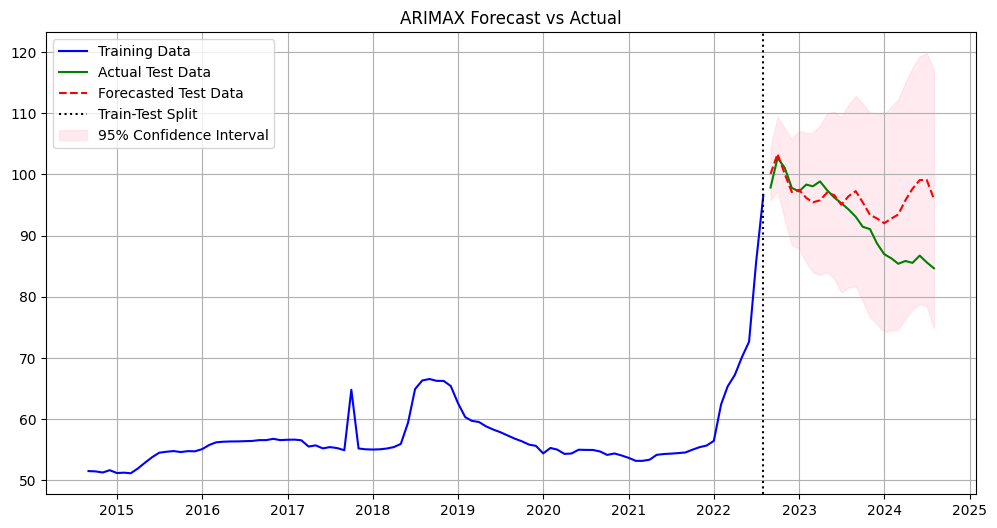

In [10]:
order = (1,1,1)
model, pred = Model(y_train, y_test, order, exog_train, exog_test) 

In [11]:
Evaluate(y_train, y_test,order, exog_train, exog_test)

Evaluation of ARIMAX(1, 1, 1)
MSE: 38.7403
MAE: 4.5580
RMSE: 6.2242
MAPE: 5.18%
AIC: 443.82
BIC: 469.36


In [12]:
confidence= model.get_forecast(steps=24, exog=exog_test).conf_int()
difference = y_test - pred
test_results = pd.DataFrame({'Test': y_test, 'Pred': pred,'Difference': difference ,'Lower': confidence.iloc[:, 0], 'Upper': confidence.iloc[:, 1]})
test_results.head(24)

,Test,Pred,Difference,Lower,Upper
2022-09-01,97.86,100.084245,-2.224245,95.768490,104.400000
2022-10-01,102.70,103.361661,-0.661661,97.258262,109.465060
2022-11-01,101.07,100.057198,1.012802,92.582091,107.532305
2022-12-01,97.79,97.111828,0.678172,88.480318,105.743338
2023-01-01,97.22,97.481514,-0.261514,87.831192,107.131835
2023-02-01,98.34,96.160368,2.179632,85.588971,106.731766
2023-03-01,98.06,95.441551,2.618449,84.023136,106.859965
2023-04-01,98.86,95.767826,3.092174,83.561028,107.974624
2023-05-01,97.43,97.025633,0.404367,84.078369,109.972898
2023-06-01,96.22,96.610867,-0.390867,82.963251,110.258482


In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                   96
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -211.911
Date:                Wed, 21 May 2025   AIC                            443.821
Time:                        01:21:58   BIC                            469.360
Sample:                    09-01-2014   HQIC                           454.141
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Production    -2.013e-07   9.53e-07     -0.211      0.833   -2.07e-06    1.67e-06
Withdrawals    2.426e-07   1.05e-06      0.232      0.817   -1.81e-06     2.3e-06
GlobalPrice      -0.0951      0.387     -0.245      0.806      -0.854       0.664
ExchangeRate      1.4974      0.435      3.440      0.001       0.644       2.351
TempMax           0.2913      0.456      0.639      0.523      -0.602       1.184
Precipitation     0.0041      0.003      1.249      0.212      -0.002       0.011
Inflation         0.8702      0.997      0.873      0.383      -1.085       2.825
ar.L1                  0      0.070          0      1.000      -0.136       0.136
ma.L1                 -0      0.070         -0      1.000      -0.136       0.136
sigma2            4.8486      0.544      8.910      0.000       3.782       5.915
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):               579.17
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               9.67   Skew:                             2.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+18. Standard errors may be unstable.
"""

In [14]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = exog.copy()

# Add constant for VIF computation
from statsmodels.tools.tools import add_constant
X = add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         Feature          VIF
0          const  1337.655812
1     Production     3.000897
2    Withdrawals     1.788540
3    GlobalPrice     1.942744
4   ExchangeRate     2.798841
5        TempMax     1.201177
6  Precipitation     2.563972
7      Inflation     2.226723


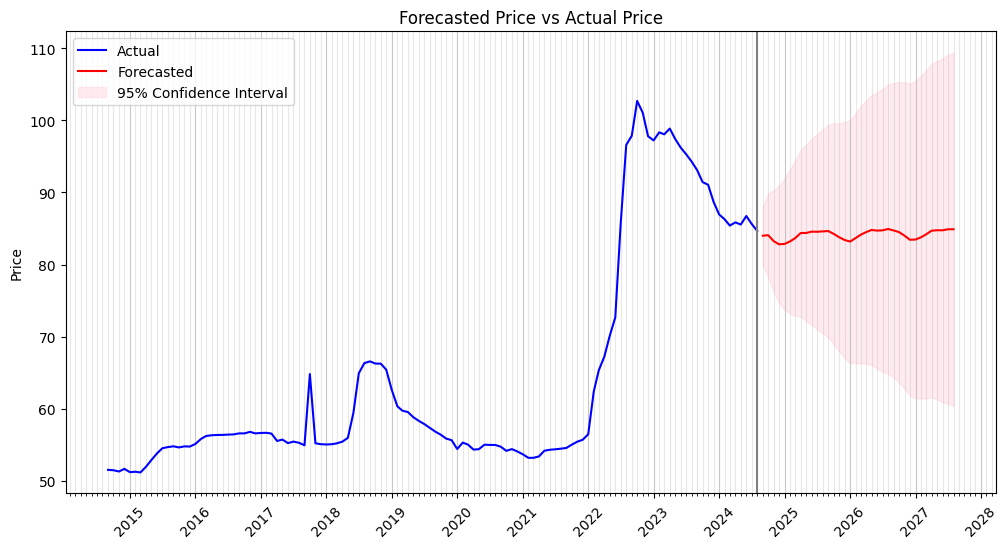

In [15]:
forecast, model = Forecast(y, order, 36, exog, future_exog)
confidence = model.get_forecast(steps=36, exog=future_exog).conf_int()

Forecasted_plot(y, forecast, confidence.values)

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -258.102
Date:                Wed, 21 May 2025   AIC                            536.203
Time:                        01:21:59   BIC                            563.995
Sample:                    09-01-2014   HQIC                           547.489
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Production    -1.542e-07   7.48e-07     -0.206      0.837   -1.62e-06    1.31e-06
Withdrawals    3.648e-07   8.57e-07      0.426      0.670   -1.31e-06    2.04e-06
GlobalPrice      -0.0193      0.240     -0.080      0.936      -0.490       0.452
ExchangeRate      1.1930      0.342      3.487      0.000       0.522       1.863
TempMax           0.3473      0.377      0.922      0.357      -0.391       1.086
Precipitation     0.0036      0.002      1.683      0.092      -0.001       0.008
Inflation         0.6672      0.732      0.911      0.362      -0.768       2.102
ar.L1                  0      0.047          0      1.000      -0.092       0.092
ma.L1                 -0      0.047         -0      1.000      -0.092       0.092
sigma2            4.3508      0.400     10.866      0.000       3.566       5.136
===================================================================================
Ljung-Box (L1) (Q):                   1.79   Jarque-Bera (JB):               932.80
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                             2.50
Prob(H) (two-sided):                  0.02   Kurtosis:                        15.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.03e+17. Standard errors may be unstable.
"""

In [17]:
latest_actual_price = [84, 83.15,83.13, 82.83, 83.65, 83.07, 83.14, 83.49] # retrieved from department of Agriculture price monitoring
forecasted_price = forecast.head(8).values.tolist()


from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse

mape_value = mape(latest_actual_price, forecasted_price) * 100
mae_value = mae(latest_actual_price, forecasted_price)
rmse_value = rmse(latest_actual_price, forecasted_price)
print(f'MAPE: {mape_value:.2f}%')
print(f'MAE: {mae_value:.2f}')
print(f'RMSE: {rmse_value:.2f}')

MAPE: 0.51%
MAE: 0.43
RMSE: 0.57


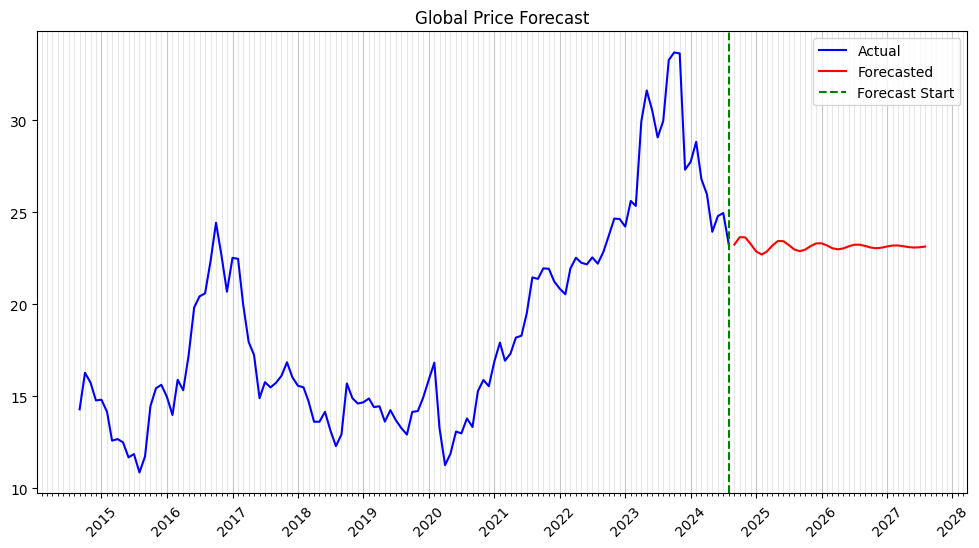

In [18]:
def Plot(actual, forecasted, title):
    plt.figure(figsize=(12,6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(forecasted, label='Forecasted', color='red')
    plt.axvline(x=actual.index[-1], color='green', linestyle='--', label='Forecast Start')

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.grid(True, which='minor', axis='x', linestyle='-', alpha=0.3) 
    plt.grid(True, which='major', axis='x', linestyle='-', alpha=0.7)
    plt.xticks(rotation=45)

    plt.title(title)
    plt.legend()
    plt.show()
    
gPrice_forecast, gPrice_model = Forecast(globalPrice, (2,1,3), 36)

Plot(globalPrice, gPrice_forecast, 'Global Price Forecast')

In [19]:
gPrice_forecast

2024-09-01    23.248338
2024-10-01    23.648147
2024-11-01    23.633300
2024-12-01    23.272099
2025-01-01    22.865266
2025-02-01    22.703388
2025-03-01    22.865331
2025-04-01    23.192723
2025-05-01    23.433734
2025-06-01    23.432062
2025-07-01    23.222781
2025-08-01    22.981096
2025-09-01    22.880376
2025-10-01    22.971290
2025-11-01    23.163553
2025-12-01    23.308691
2026-01-01    23.311896
2026-02-01    23.190757
2026-03-01    23.047273
2026-04-01    22.984803
2026-05-01    23.035671
2026-06-01    23.148506
2026-07-01    23.235825
2026-08-01    23.240192
2026-09-01    23.170145
2026-10-01    23.085014
2026-11-01    23.046380
2026-12-01    23.074736
2027-01-01    23.140913
2027-02-01    23.193397
2027-03-01    23.197436
2027-04-01    23.156975
2027-05-01    23.106499
2027-06-01    23.082668
2027-07-01    23.098408
2027-08-01    23.137195
Freq: MS, Name: Forecast, dtype: float64

In [20]:
comparision_GlobalPrice = pd.DataFrame({'X3' : x3, 'Forecast:' : gPrice_forecast})
comparision_GlobalPrice.head(24)

,X3,Forecast:
2024-09-01,22.589705,NaN
2024-10-01,22.416926,NaN
2024-11-01,22.366675,NaN
2024-12-01,22.543888,NaN
2025-01-01,22.664605,NaN
2025-02-01,22.609542,NaN
2025-03-01,22.503477,NaN
2025-04-01,22.447384,NaN
2025-05-01,22.503389,NaN
2025-06-01,22.575841,NaN
